<a href="https://colab.research.google.com/github/ShellyLeee/UCSD-DSC-190-Trustworthy-Machine-Learning/blob/main/PA_Part_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PA - Part I: Basic Vision Models [Experiments with MNIST]*** (55pt)

**Keywords**: Multiclass Image Classification, Neural Networks, PyTorch

**MNIST**
* The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
* The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.
* However to speed up computations, we will use a much smaller dataset with size $8\times 8$ images. These images are loaded from `sklearn.datasets`.

**Agenda**:
* The PA is split into three parts, the first part dealing with miniature models which we will build from scratch, the second part dealing with modern architectures and the bonus third part dealing with training vision models robust to adversarial attacks.
* In this part, we will be performing multiclass classification on the simplified MNIST dataset from scratch.
* We will be applying and analysing different loss functions, optimization techniques and learning methods.

* We will be using PyTorch to do most of the heavylifting for modeling and training.

**Note:**
* Hardware acceleration (GPU) is recommended but not required for this part.
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* Only **add your code** to cells marked with "TODO:" or with "..."
* You should not have to change variable names where provided, but you are free to if required for your implementation.



---



### ***Setup: Imports and Utils***

In [ ]:
# imports
import torch
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# loading the dataset directly from the scikit-learn library
dataset = load_digits()
X = dataset.data
y = dataset.target
print('Number of images:', X.shape[0])
print('Number of features per image:', X.shape[1])

Number of images: 1797
Number of features per image: 64


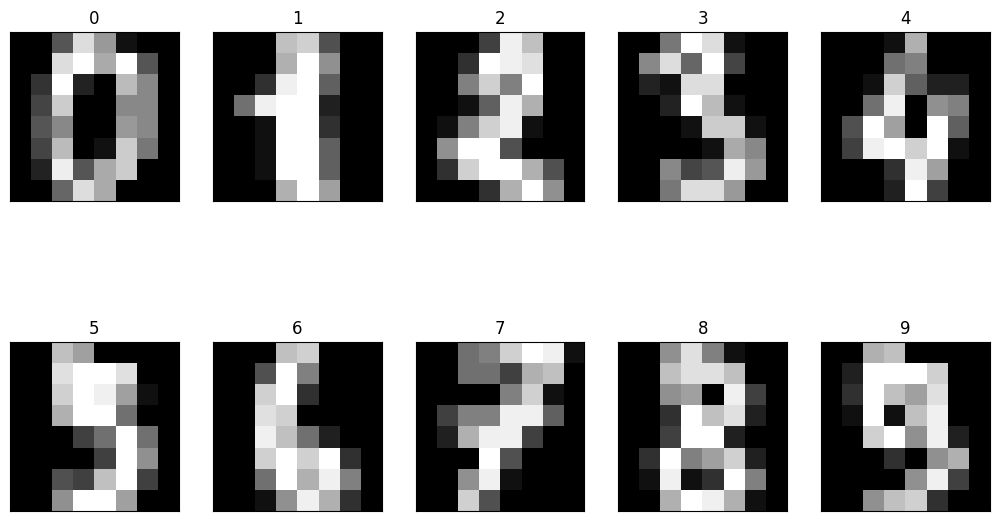

In [ ]:
# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# visualize some of the images of the MNIST dataset
plot_gallery(X, y, 8, 8, 2, 5)

In [ ]:
# Let us split the dataset into training and test sets in a stratified manner.
# Note that we are not creating evaluation datset as we will not be tuning hyper-parameters
# The split ratio is 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of train dataset:', X_train.shape)
print('Shape of evaluation dataset:', X_test.shape)

Shape of train dataset: (1437, 64)
Shape of evaluation dataset: (360, 64)


In [ ]:
# define some constants - useful for later
num_classes = len(np.unique(y)) # number of target classes = 10 -- (0,1,2,3,4,5,6,7,8,9)
num_features = X.shape[1]       # number of features = 64
max_epochs = 100000             # max number of epochs for training
lr = 1e-2                       # learning rate
tolerance = 1e-6                # tolerance for early stopping during training

In [ ]:
# Hardware Acceleration: to set device if using GPU.
# You can change runtime in colab by naviagting to (Runtime->Change runtime type), and selecting GPU in hardware accelarator.
# NOTE that you can run this homework without GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'



---



### *(a) Utils and pre-processing* (5pt)

* Scale the image data between 0 and 1
* One-hot encode the target data
* Convert the data to tensors and move them to the required device

In [ ]:
# 1. Scale the features between 0 and 1
# To scale, you can directly use the MinMaxScaler from sklearn.
#######
#TODO:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# output variable names -  X_train, X_test
#######
print(X_train)
print(X_test)

[[0.     0.     0.6875 ... 0.125  0.     0.    ]
 [0.     0.     0.125  ... 0.0625 0.     0.    ]
 [0.     0.125  0.9375 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.0625 ... 0.1875 0.     0.    ]
 [0.     0.     0.25   ... 0.     0.     0.    ]
 [0.     0.     0.1875 ... 1.     1.     0.1875]]
[[0.         0.         0.5        ... 0.25       0.         0.        ]
 [0.         0.42857143 1.         ... 0.5        0.1875     0.        ]
 [0.         0.         0.125      ... 0.0625     0.         0.        ]
 ...
 [0.         0.         0.625      ... 0.1875     0.         0.        ]
 [0.         0.         0.4375     ... 0.75       0.         0.        ]
 [0.         0.         0.         ... 0.125      0.         0.        ]]


In [ ]:
# 2. One-Hot encode the target labels
# To one-hot encode, you can use the OneHotEncoder from sklearn
#######
#TODO:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1)) # Reshape: ohe need a 2d-array input
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))

# output variable names -  y_train_ohe, y_test_ohe
#######
print('Shape of y_train_ohe:',y_train_ohe.shape)
print('Shape of y_test_ohe:',y_test_ohe.shape)


# move X and y to the defined device and convert them to torch.float32
X_train_torch = ...
X_test_torch = ...
y_train_ohe_torch = ...
y_test_ohe_torch = ...

# output variable names -  X_train_torch, X_test_torch, y_train_ohe_torch, y_test_ohe_torch

Shape of y_train_ohe: (1437, 10)
Shape of y_test_ohe: (360, 10)


### *(b) Implement Multi-Class Logistic Regression from scratch* (15pt)

In this problem, we will apply multiclass logistic regression from scratch  trained using gradient descent (GD) with Mean Squared Error (MSE) loss as the objective.

We will be using a linear model $y^{(i)} = W \mathbf{x}^{(i)}$, with the following notations:

* Weight matrix:
$ W_{p\times n}= \begin{bmatrix}
\leftarrow & \mathbf{w}_1^\top & \rightarrow \\
\leftarrow & \mathbf{w}_2^\top & \rightarrow\\
 & \vdots &  \\
\leftarrow & \mathbf{w}_p^\top & \rightarrow \\
\end{bmatrix}$, where $p$ is the number of target classes

* data points: $\mathbf{x}^{(i)}\in \mathbb{R}^n, y^{(i)}\in \mathbb{R}$, and $X = \begin{bmatrix}
\uparrow &  \uparrow & \dotsm &  \uparrow\\
\mathbf{x}^{(1)} & \mathbf{x}^{(2)} & \dotsm & \mathbf{x}^{(m)} \\
\downarrow & \downarrow  & \dotsm & \downarrow  \\
\end{bmatrix}, Y = \begin{bmatrix}
y^{(1)}\\
y^{(2)} \\
\vdots \\
y^{(m)} \\
\end{bmatrix}$, where $m$ is the number of datapoints.

**Note:** Here we need to define the model prediction. The input matrix is $X_{n\times m}$ where $m$ is the number of examples, and $n$ is the number of features. The linear predictions can be given by: $Y = WX + b$ where $W$ is a $p\times n$ weight matrix and $b$ is a $p$ size bias vector. $p$ is the number of target classes.

#### #1. Define a function `linear_model`

* This function takes as input a weight matrix (`W`), bias vector (`b`), and input data matrix of size $m\times n$ (`XT`).
* This function should return the predictions $\hat{y}$, which is an $m\times p$ matrix. For each datapoint row which is a $1 \times p$ vector, the prediction can be seen as the scores that the model gives each target class for that datapoint

In [ ]:
#######
def linear_model(W, b, XT):
    #TODO:
    ...
    return y_hat

#######

**Note:** The loss function that we would be using is the Mean Square Error (L2) Loss:\
$\displaystyle MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, where $m$ is the number of examples, $\hat{y}^{(i)}$ is the
predicted value of $x^{(i)}$ and $y^{(i)}$ is the ground truth of $x^{(i)}$.

#### #2. Define a function `mse_loss`

* This function takes as input prediction (`y_pred`) and ground-truth label (`y`), and returns the MSE loss.

In [ ]:
#######
def mse_loss(y_pred, y):
    #TODO:
    ...
    return loss

#######


#### #3. Define a function: `initializeWeightsAndBiases`

In this part, we will do some setup required for training (such as initializing weights and biases) and move everything to torch tensors.


* This function returns tuple `(W, b)`, where `W` is a randomly generated torch tensor of size `num_classes x num_features`, and `b` is a randomly generated torch vector of size `num_classes`.
* For both the tensors, set `requires_grad=True` in parameters.



In [ ]:
#######
def initializeWeightsAndBiases(num_classes, num_features):
    #TODO:
    W = ...
    b = ...
    return W, b
#######

#### #4 Training code

* Given below is a function: `train_linear_regression_model` that takes as inputs as max number of epochs (`max_epochs`), weights (`W`), biases (`b`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`).
* This function returns a tuple `(W,b,losses)` where `W,b` are the trained weights and biases respectively, and `losses` is a list of tuples of loss logged every $100^{th}$  epoch.
* You can go through [this](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-tensors-and-autograd) article for reference.

In [ ]:
# Define a function train_linear_regression_model
def train_linear_regression_model(max_epochs, W, b, X_train, y_train, lr, tolerance):
  #TODO:
  losses = []
  prev_loss = float('inf')

  for epoch in tqdm(range(max_epochs)):

      #######
      # 7. do prediction
      y_pred = ...

      # 8. get the loss
      loss = ...

      # 9. backpropagate loss
      ...

      # 10. update the weights and biasees
      ...

      # 11. set the gradients to zero
      ...

      #######

      # log the loss every 100th epoch and print every 5000th epoch:
      if epoch%100==0:
        losses.append((epoch, loss.item()))
        if epoch%5000==0:
          print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

      # break if decrease in loss is less than threshold
      ...

  # return updated weights, biases, and logged losses
  return W, b, losses

#### #5. Initialize parameters and train your own model

* Initialize weights and biases using the `initializeWeightsAndBiases` function that you defined earlier
* Train your model using function `train_linear_regression_model` defined above.
* Use full batch (set `batch_size=len(X_train)` for training (Gradient Descent).
* Also plot the graph of loss vs number of epochs (Recall that values for learning rate (`lr`) and tolerance (`tolerance`) are already defined above).

In [ ]:
#######
#TODO:
W, b = ...
W, b, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
predictions_train = ...
predictions_test = ...
y_train_pred = ...

y_test_pred = ...
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

### *(c) Use PyTorch for training* (10pt)

* In the previous part, we defined the model, loss, and even the gradient update step. We also had to manually set the gradients to zero.
* In this part, we will re-implement the linear model and see how we can directly use Pytorch to do all this for us in a few simple steps.

In [ ]:
# common utility function to print accuracies
def print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test):
  predictions_train = ...
  predictions_test = ...
  y_train_pred = ...
  y_test_pred = ...
  print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
  print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

#### #1. Define the linear model using PyTorch

* Use the inbuilt PyTorch `torch.nn.Module` to define a model class.
* Use the `torch.nn.Linear` to define the linear layer of the model

In [ ]:
#######
# Define a model class using torch.nn
class Linear_Model(torch.nn.Module):
  def __init__(self):
    super(Linear_Model, self).__init__()
    # Initalize various layers of model as below
    # 1. initialze one linear layer: num_features -> num_targets
    ...

  def forward(self, X):
    # 2. define the feedforward algorithm of the model and return the final output
    ...
    return

#######

#### #2. A general function for training a PyTorch model.

Define a general training function: `train_torch_model`.
* This function takes as input an initialized torch model (`model`), batch size (`batch_size`), initialized loss (`criterion`), max number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`).
* This function will return a tuple `(model, losses)`, where `model` is the trained model, and `losses` is a list of tuples of loss logged every $100^{th}$ epoch.

Note: You can reuse a lot of components from the `train_linear_regression_model` function from the previous section

You can go through [this](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim) article for reference.

In [ ]:
# Define a function train_torch_model
def train_torch_model(model, batch_size, criterion, max_epochs, X_train, y_train, lr, tolerance):
  losses = []
  prev_loss = float('inf')
  number_of_batches = math.ceil(len(X_train)/batch_size)

  #######
  # 3. move model to device
  ...

  # 4. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
  # Set learning rate to lr and also set model parameters
  optimizer =  ...

  for epoch in tqdm(range(max_epochs)):
    for i in range(number_of_batches):
      X_train_batch = ...
      y_train_batch = ...

      # 5. reset gradients
      ...

      # 6. prediction
      prediction = ...

      # 7. calculate loss
      loss = ...

      # 8. backpropagate loss
      ...

      # 9. perform a single gradient update step
      ...

  #######

    # log loss every 100th epoch and print every 5000th epoch:
    if epoch%100==0:
      losses.append((epoch, loss.item()))
      if epoch%5000==0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    # break if decrease in loss is less than threshold
    ...

  # return updated model and logged losses
  return model, losses

### *(d) Working with different model types* (15pt)
* Now, we retrain the above model with `batch_size=64`
* Use Stochastic/Mini-batch Gradient Descent and keep everything else the same.
* Like before, we plot the graph between loss and number of epochs.

#### #1. MSE Loss and Gradient Descent (GD)
* Use `nn.MSELoss`.
* Use full batch for training (Gradient Descent).
* Also plot the graph of loss vs number of epochs.

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

#### #2. MSE Loss and Stochastic Gradient Descent (SGD)
* Use `nn.MSELoss`.
* Use `batch_size=64` for training
* Also plot the graph of loss vs number of epochs.

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)



---



#### **Cross-Entropy (CE) Loss with Linear Model**
* Instead of using MSE Loss, we will use a much more natural loss function for the multi-class logistic regression task which is the Cross Entropy Loss.
* CE loss converts the model scores of each class into a probability.
* This model penalizes both choosing the wrong class as well as uncertainty (choosing the right class with low probability).
* And we will use the same linear model defined in **(c)**.


**Note:**
The [Cross Entropy Loss](https://ebookreading.net/view/book/EB9781789130331_73.html) for multiclass classification is the mean of the negative log likelihood of the output logits after softmax:\
$L = \underbrace{\frac{1}{m} \sum_{i=1}^m \underbrace{-y^{(i)} \underbrace{log \underbrace{\frac{e^{\hat{y}^{(i)}}}{\sum_{j=1}^p e^{\hat{y}^{(j)}}}}_{\text{Softmax}}}_{\text{LogSoftmax}}}_{\text{Negative Log Likelihood (NLL)}}}_{\text{Cross Entropy (CE) Loss }}$,


where $y^{(i)}$ is the ground truth, and $\hat{y}^{(k)}$ (also called as *logits*) represent the outputs of the last linear layer of the model.

#### #3. CE Loss and GD
* Instead of `nn.MSELoss`, train the linear model with `nn.CrossEntropyLoss`.
* Use **full-batch**.
* Also plot the graph between loss and number of epochs.

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

#### #4. CE Loss and SGD
* Use a different batch size, `batch_size=64` with the new loss and repeat the previous part #1.
* Also plot the graph of loss vs epochs.

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)



---



#### **Training a neural network model in PyTorch**

* We will train a neural network in pytorch with two hidden layers of sizes 32 and 16 neurons.
* We will use non-linear ReLU activations to effectively make it a non-linear model.
* We will use this neural network model for multi-class classification with Cross Entropy Loss.

**Note:** The neural network model output can be represented mathematically as below:
$\hat{y}^{(i)}_{10\times1} = W^{(3)}_{10\times 16}\sigma(W^{(2)}_{16\times 32}\sigma(W^{(1)}_{32\times 64}\mathbf{x}^{(i)}_{64\times1}+\mathbf{b}^{(1)}_{32\times1})+\mathbf{b}^{(2)}_{16\times1})+\mathbf{b}^{(3)}_{10\times1}$,
where $\sigma$ represents ReLU activation, $W^{(i)}$ is the weight of the $i^{th}$ linear layer, and $\mathbf{b}^{(i)}$ is the layer's bias. We use the subscript to denote the dimension for clarity.

#### #5. Define the 2 hidden-layer Neural Network (NN)

In [ ]:
#######
# Define a neural network model class using torch.nn
class NN_Model(torch.nn.Module):
  def __init__(self):
    super(NN_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialize three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
    ...

    # 2. initialize RELU
    ...

  def forward(self, X):
    # 3. define the feedforward algorithm of the model and return the final output
    # Apply non-linear ReLU activation between subsequent layers
    ...
    return

#######

#### #6. NN with CE Loss and GD
* Use Cross Entropy Loss.
* Use full-batch and plot the graph of loss vs number of epochs.
* Note that you can re-use the training function `train_torch_model` (from part (b)).

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

#### #7. NN with CE Loss and SGD
* Re-train the above model with `batch_size=64`.
* Also plot the graph of loss vs epochs.

In [ ]:
#######
model = ...
criterion = ...
batch_size = ...
model, losses = ...

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [ ]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)



---



### *(e) Analyze the results* (10pt)

In the above few examples, we performed several experiments with different batch size and loss functions. Now it's time to analyze our observations from the results.

Recall that we trained the following models in this tutorial:

1.   Linear Model - Scratch + MSE Loss + Full Batch (GD)
2.   Linear Model - PyTorch + MSE Loss + Full Batch
3.   Linear Model - PyTorch + MSE Loss + Mini Batch (SGD)
4.   Linear Model - PyTorch + CE Loss + Full Batch
5.   Linear Model - PyTorch + CE Loss + Mini Batch
6.   NN Model - PyTorch + CE Loss + Full Batch
7.   NN Model - PyTorch + CE Loss + Mini Batch


In [ ]:
# plotting graph of accuracy vs model
import pandas as pd
import plotly.express as px
xlabels = ['linear-scratch', 'linear-torch-full', 'linear-torch-batch', 'linear-celoss-full', 'linear-celoss-batch', 'nn-full', 'nn-batch']
train_accuracies = [..., ..., ..., ..., ..., ..., ...]
test_accuracies = [..., ..., ..., ..., ..., ..., ...]

tuples = [(xlabels[i],train_accuracies[i], 'train' ) for i in range(len(xlabels))]+[(xlabels[i],test_accuracies[i], 'test' ) for i in range(len(xlabels))]
df = pd.DataFrame(tuples, columns = ['model', 'accuracy', 'type'])
px.line(df, x='model', y='accuracy', color = 'type', markers=True, title = 'accuracy vs. model')

#### #1.Analysis
**Effect of using full vs. batch gradient descent:**


**Effect of using different loss strategy:**


**Effect of using linear vs. non-linear models:**


**Training time per epoch in different cases:**